##### This function predicts the sales based on a particular store_id. 

C:\Users\hp\AppData\Local\Temp\ipykernel_19932\1049995997.py:14: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_store['Date'] = pd.to_datetime(df_store['Date'])


There are no records with a value of 0
The series 12 is stationary


C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\hp\anaconda3\lib\site-packages\statsmodels\base\mo

                    rmse
(8, 0, 3)   96240.725848
(7, 0, 3)   97745.069727
(1, 0, 4)   98068.207799
(9, 0, 4)   98578.185276
(7, 0, 0)   98994.186560
...                  ...
(4, 1, 1)  462320.001189
(4, 1, 0)  488773.663199
(2, 1, 2)  494418.219393
(1, 1, 0)  596855.772730
(0, 1, 0)  596855.780853

[200 rows x 1 columns]


C:\Users\hp\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


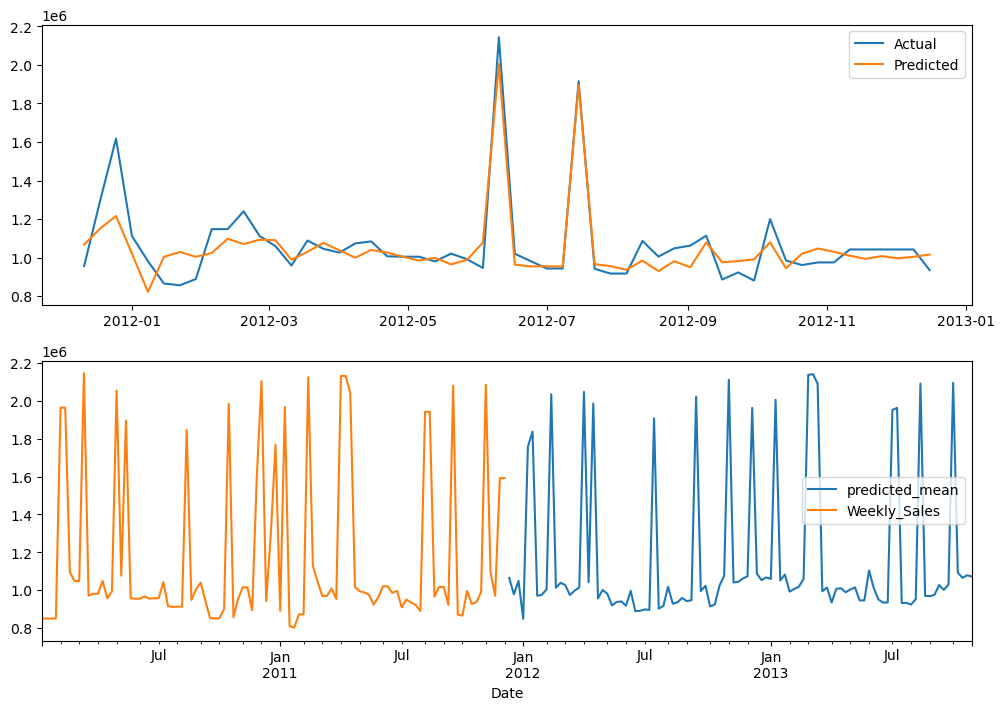

In [1]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import itertools
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

def time_series_model(store_no):
    flag=0
    df = pd.read_csv('w.csv')
    df_store = df[df['Store'] == store_no]
    df_store = df_store[['Date', 'Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI']]
    df_store['Date'] = pd.to_datetime(df_store['Date'])
    df_store.set_index(['Date'], inplace=True)
    df_store = df_store.sort_index()
    df_store = df_store.resample('W').sum()
    df_store.replace(0, np.nan, inplace=True)
    df_store = df_store.interpolate(method='pad')
    conv_count = (df_store['Weekly_Sales'] == 0).sum()

    if conv_count == 0:
        print("There are no records with a value of 0")
    else:
        print("There are {} records with a value of 0".format(conv_count))

    result = adfuller(df_store['Weekly_Sales'])

    if result[1] > 0.05:
        print("The series {} is not stationary".format(store_no))
        print("Performing first order Differencing")
        df_store['Weekly_Sales']=df_store['Weekly_Sales'].diff()
        df_store=df_store.dropna()
        result = adfuller(df_store['Weekly_Sales'])
        if result[1] > 0.05:
            print("Still the series is not stationary")
        else:
            print("Now {} is stationary".format(store_no))
        
    else:
        print("The series {} is stationary".format(store_no))

    train = df_store.iloc[:100]
    test = df_store.iloc[100:]        

    p = range(0, 10)
    d = range(0, 2)
    q = range(0, 10)
    rmse = []
    values = []
    pdq_combination = list(itertools.product(p, d, q))

    for col in pdq_combination:
        model = ARIMA(train['Weekly_Sales'], order=col, exog=train[['Temperature', 'Fuel_Price', 'CPI']])
        model_fit = model.fit()
        predicted = model_fit.predict(start=len(train), end=len(train)+len(test)-1, exog=test[['Temperature', 'Fuel_Price', 'CPI']])
        error = np.sqrt(mean_squared_error(predicted, test['Weekly_Sales']))
        rmse.append(error)
        values.append(col)

    new_df1 = pd.DataFrame(index=values, data=rmse, columns=['rmse'])    
    new_df2 = new_df1.sort_values('rmse')
    print(new_df2)
    pdq=new_df2.index[0]
    model1 = ARIMA(train['Weekly_Sales'], order=pdq, exog=train[['Temperature', 'Fuel_Price', 'CPI']])
    model1_fit = model1.fit()
    predictions1 = model1_fit.predict(start=len(train), end=len(train)+len(test)-1, exog=test[['Temperature', 'Fuel_Price', 'CPI']])
    predictions1_converted=predictions1.reset_index(drop=True)
        # Reset the index of the 'test1' dataframe to include 'date' as a regular column
    test_copy=test
    test_copy=test_copy.reset_index()
    test_copy['predicted'] = predictions1_converted
        # Set 'date' column as the index again
    test_copy.set_index('Date', inplace=True)
    test_copy=test_copy[['Weekly_Sales','predicted']]
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    axes[0].plot(test_copy.index,test_copy['Weekly_Sales'],label='Actual')
    axes[0].plot(test_copy.index,test_copy['predicted'],label='Predicted')
    axes[0].legend()
    forecast=model1_fit.forecast(steps=100,exog=train[['Temperature', 'Fuel_Price', 'CPI']])
    forecast.plot()
    train['Weekly_Sales'].plot()
    plt.legend()

    

    

# Call the function with the desired store number
time_series_model(12)


##### The code provided in the subsequent cells is divided into two sections. The first section demonstrates the exploratory data analysis process, where insights were derived from the data. The second section outlines the steps followed to create the specific function.


# Exploratory data analysis

In [2]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import itertools
import numpy as np
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df=pd.read_csv('w.csv')

In [4]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [5]:
df.shape

(6435, 8)

In [6]:
df.isnull().sum()


Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [8]:
df['Store'].value_counts()

1     143
24    143
26    143
27    143
28    143
29    143
30    143
31    143
32    143
33    143
34    143
35    143
36    143
37    143
38    143
39    143
40    143
41    143
42    143
43    143
44    143
25    143
23    143
2     143
22    143
3     143
4     143
5     143
6     143
7     143
8     143
9     143
10    143
11    143
12    143
13    143
14    143
15    143
16    143
17    143
18    143
19    143
20    143
21    143
45    143
Name: Store, dtype: int64

### Relationship Between Sales and Holiday Week

In [9]:
df.groupby('Holiday_Flag')['Weekly_Sales'].sum()

Holiday_Flag
0    6.231919e+09
1    5.052996e+08
Name: Weekly_Sales, dtype: float64

### Store_ID With Sales


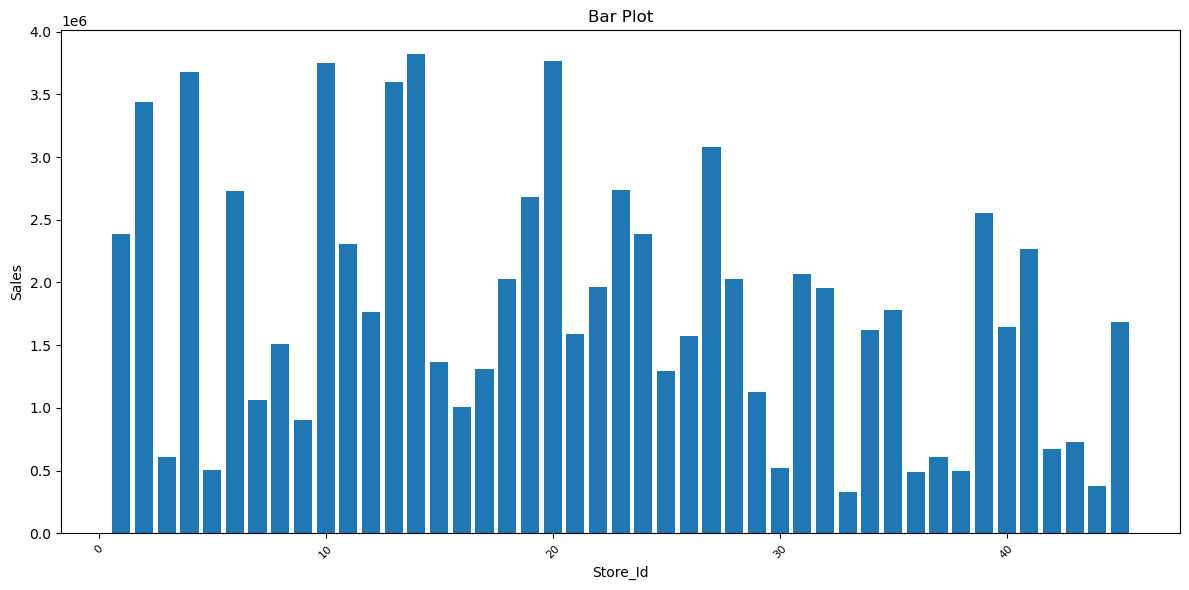

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 6))
bar_plot = plt.bar(df['Store'],df['Weekly_Sales'])
plt.xlabel('Store_Id')
plt.ylabel('Sales')
plt.title('Bar Plot')
plt.xticks(rotation=45)  
plt.tick_params(axis='x', labelsize=8)
plt.tight_layout()  
plt.show()


In [9]:
k=df.groupby('Store')['Weekly_Sales'].sum()

In [12]:
print("Based on the historical data we can conclude that Store No {} achieved maximum total sales of {} and store ID {} achieved the minimum sales with a value of {}  ".format(k.idxmax(),k.max(),k.idxmin(),k.min()))

Based on the historical data we can conclude that Store No 20 achieved maximum total sales of 301397792.46 and store ID 33 achieved the minimum sales with a value of 37160221.96  


In [13]:
print("The difference between the highest anbd lowest sales value : {}".format(k.max()-k.min()))

The difference between the highest anbd lowest sales value : 264237570.49999997


### Consumer Price Index with Weekly sales

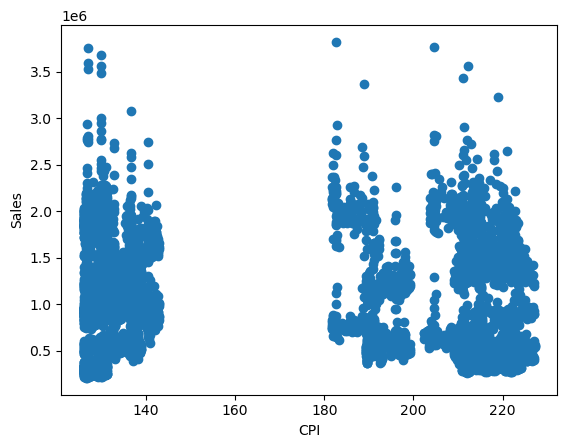

In [7]:
plt.scatter(df['CPI'],df['Weekly_Sales'])
plt.xlabel("CPI")
plt.ylabel("Sales")
plt.show()



In [8]:
print("The Consumer Price Index column has a correlation of {} with Sales column".format(df['CPI'].corr(df['Weekly_Sales'])))

The Consumer Price Index column has a correlation of -0.07263416204017631 with Sales column


### Unemployment  with Weekly_Sales

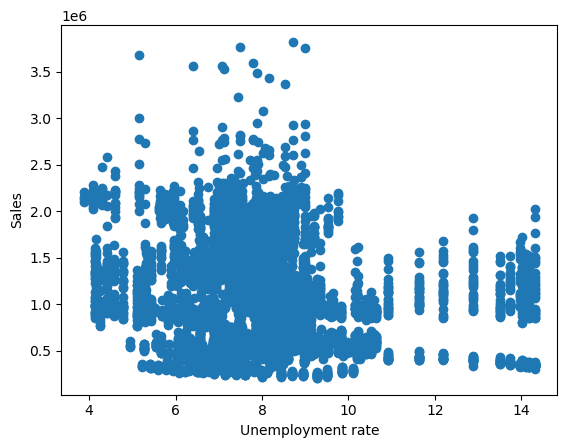

In [14]:
plt.scatter(df['Unemployment'],df['Weekly_Sales'])
plt.xlabel("Unemployment rate")
plt.ylabel("Sales")
plt.show()


In [15]:
print("The unemployment rate column has a correlation of {} with Sales column".format(df['Unemployment'].corr(df['Weekly_Sales'])))

The unemployment rate column has a correlation of -0.10617608965795419 with Sales column


### Temperature with sales

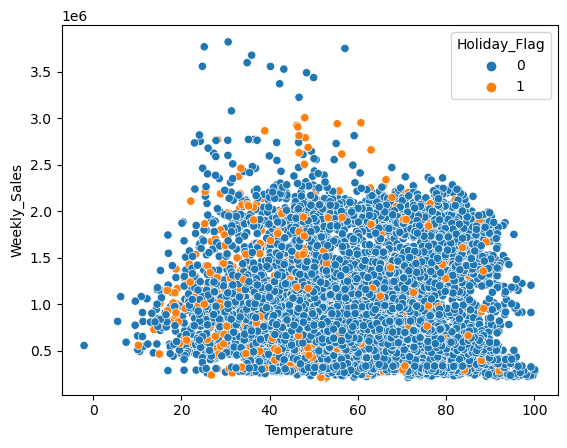

The temperature column has a correlation of -0.06381001317946962 with Sales column


In [16]:
sns.scatterplot(x=df['Temperature'],y=df['Weekly_Sales'],hue=df['Holiday_Flag'])
plt.show()
print("The temperature column has a correlation of {} with Sales column".format(df['Temperature'].corr(df['Weekly_Sales'])))

In [17]:
df_new=df.copy()

In [18]:
df_new['Date']=pd.to_datetime(df_new['Date'])

C:\Users\hp\AppData\Local\Temp\ipykernel_19932\1555004364.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_new['Date']=pd.to_datetime(df_new['Date'])


In [19]:
df_new['Month']=df_new['Date'].dt.month

In [20]:
df_new1=df_new.sort_values(by='Date',ascending=True)

### Month With Sales

In [21]:
df_new_test=df_new.groupby('Month')['Weekly_Sales'].mean()

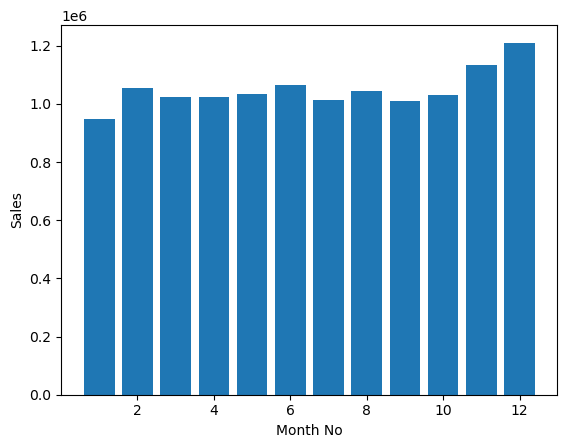

In [22]:
plt.bar(df_new_test.index,df_new_test.values)
plt.xlabel("Month No")
plt.ylabel("Sales")
plt.show()



# Steps Followed to Create the Time Series Forecasting Function

In [23]:
df_store_1=df[df['Store']==1]
df_store_1=df_store_1[['Date','Weekly_Sales']]
df_store_1['Date']=pd.to_datetime(df_store_1['Date'])
df_store_1.set_index(['Date'],inplace=True)
df_store_1=df_store_1.sort_index()
df_store_1=df_store_1.resample('W').sum()


C:\Users\hp\AppData\Local\Temp\ipykernel_19932\311203960.py:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_store_1['Date']=pd.to_datetime(df_store_1['Date'])


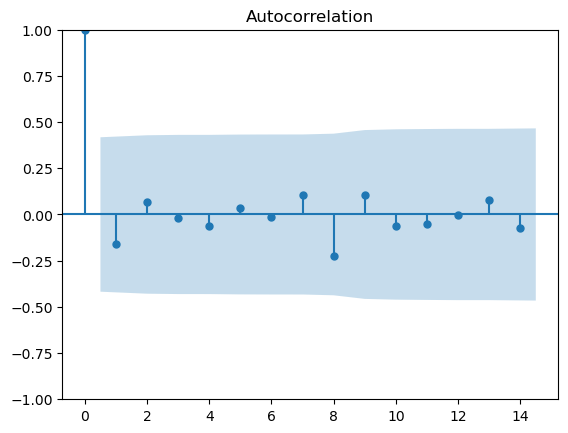

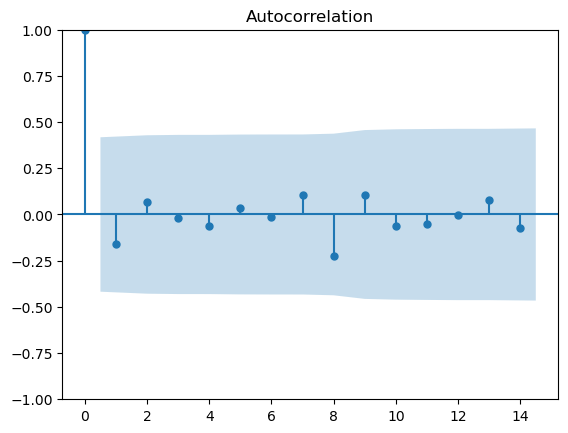

In [24]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
acf_plot1=acf(df_store_1.dropna())
plot_acf(acf_plot1)

C:\Users\hp\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


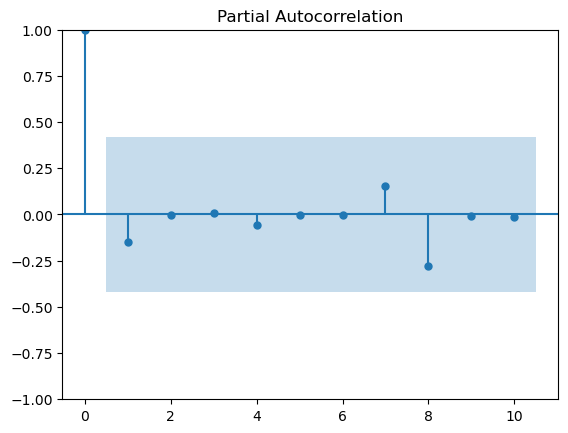

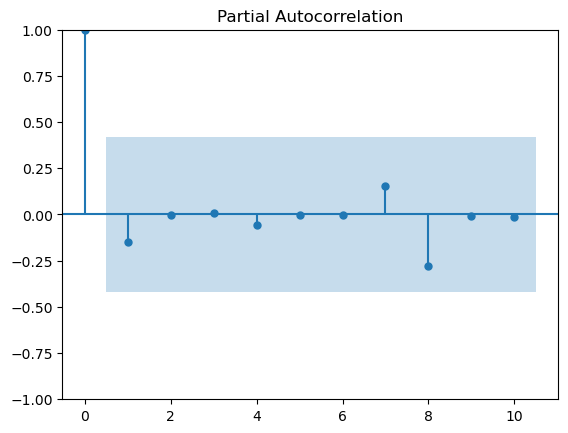

In [25]:
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
pacf_plot1=pacf(df_store_1.dropna())
plot_pacf(pacf_plot1,lags=10)

It is evident from the graph that there exists no seasonality within the particular dataframe

### Seasonality check using line decomposition technique


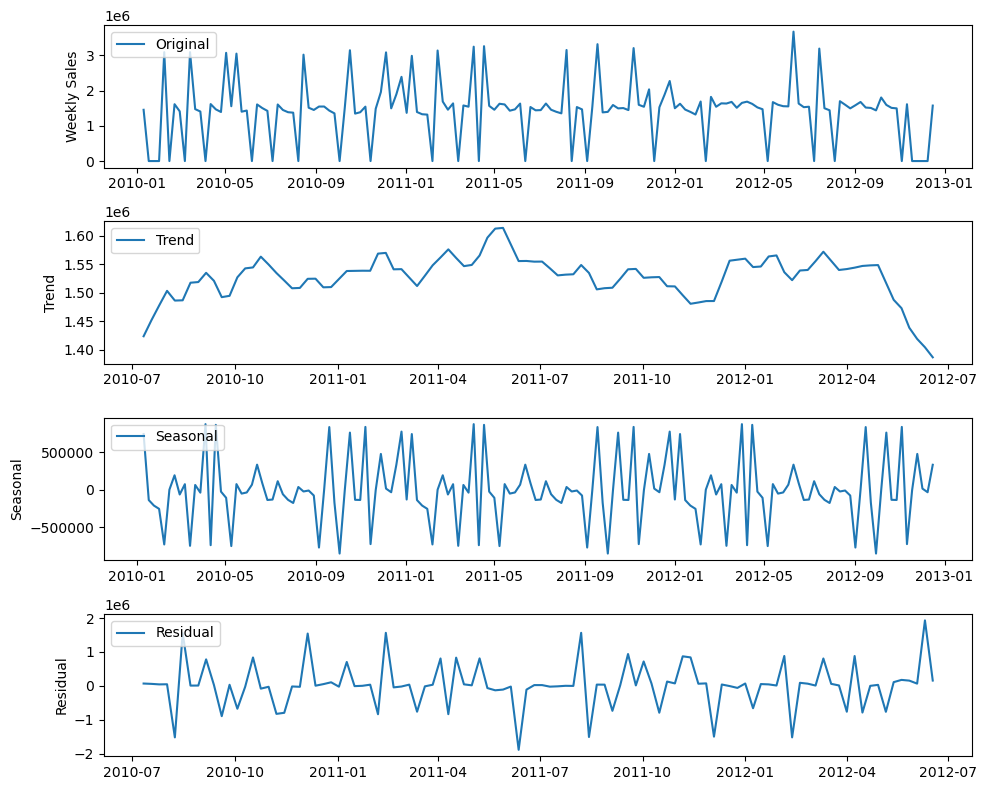

In [26]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Assuming your data is stored in the 'df_store_1' DataFrame with a datetime index

# Extract the 'Weekly_Sales' column from the DataFrame
weekly_sales = df_store_1['Weekly_Sales']

# Perform seasonal decomposition
decomposition = seasonal_decompose(weekly_sales, model='additive')

# Plot the decomposition components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))
ax1.plot(weekly_sales, label='Original')
ax1.legend(loc='upper left')
ax1.set_ylabel('Weekly Sales')

ax2.plot(decomposition.trend, label='Trend')
ax2.legend(loc='upper left')
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal, label='Seasonal')
ax3.legend(loc='upper left')
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid, label='Residual')
ax4.legend(loc='upper left')
ax4.set_ylabel('Residual')

plt.tight_layout()
plt.show()


 From the visualization seasonality is not captured accurately so seasonal interpolation technique cannot be used.Padding interpolation [Filling with the recent observation] can be considered

### Pad interpolation

In [27]:
df_store_1.replace(0, np.nan, inplace=True)
df_store_1 =df_store_1.interpolate(method='pad')


In [28]:
from statsmodels.tsa.stattools import adfuller
result1=adfuller(df_store_1)
if result1[1]>0.05:
    print("The series is not stationary")
else:
    print("The series is stationary")

The series is stationary


In [29]:
# if df_store_1['Weekly_Sales'].isnull().any():
#     df_store_1 = df_store_1.dropna()

In [30]:
train1=df_store_1.iloc[:100]
test1=df_store_1.iloc[100:]

In [31]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [32]:
from sklearn.metrics import mean_squared_error
import itertools
import numpy
p=range(0,10)
d=range(0,2)
q=range(0,10)
rmse=[]
values=[]
pdq_combination=list(itertools.product(p,d,q))
for col in pdq_combination:
    model=ARIMA(train1,order=col)
    model_fit=model.fit()
    predicted=model_fit.predict(start=len(train1),end=len(train1)+len(test1)-1,dynamic=True)
    error=np.sqrt(mean_squared_error(predicted,test1))
    rmse.append(error)
    values.append(col)
new_df1=pd.DataFrame(index=values,data=rmse,columns=['rmse'])    
new_df2=new_df1.sort_values('rmse')
new_df2    
    


C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.p

,rmse
"(4, 0, 3)",391748.883176
"(8, 0, 6)",393541.021913
"(1, 1, 4)",393705.016534
"(1, 1, 3)",393849.139377
"(2, 1, 3)",393849.405637
...,...
"(2, 1, 0)",484636.444063
"(5, 1, 0)",513642.011741
"(4, 1, 0)",513790.048597
"(1, 1, 0)",533156.454997


In [33]:
model2=ARIMA(train1,order=(4,0,3))
model_fit=model2.fit()
predictions1=model_fit.predict(start=len(train1),end=len(train1)+len(test1)-1,dynamic=True)


C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\hp\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: xlabel='Date'>

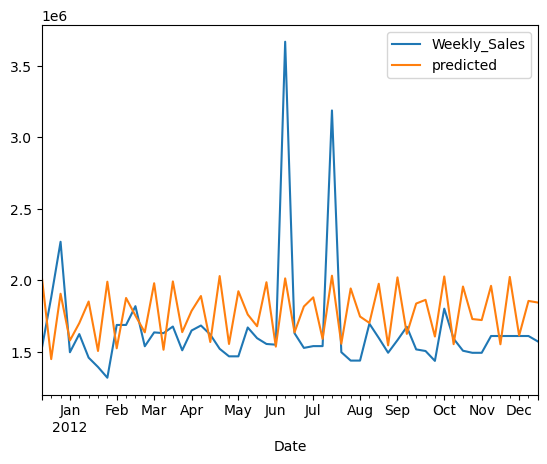

In [34]:
predictions1_converted=predictions1.reset_index(drop=True)
# Reset the index of the 'test1' dataframe to include 'date' as a regular column
test1_copy=test1
test1_copy=test1_copy.reset_index()
test1_copy['predicted'] = predictions1_converted

# Set 'date' column as the index again
test1_copy.set_index('Date', inplace=True)
test1_copy=test1_copy[['Weekly_Sales','predicted']]
test1_copy[['Weekly_Sales','predicted']].plot()


<Axes: xlabel='Date'>

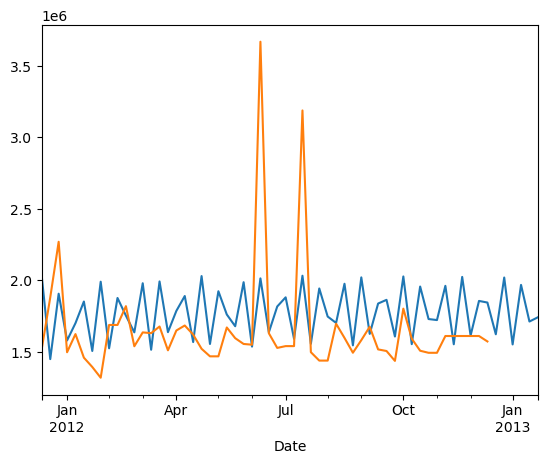

In [35]:
forecast1=model_fit.forecast(steps=60)
#forecast1_converted=forecast1.reset_index(drop=True)
# Reset the index of the 'test1' dataframe to include 'date' as a regular column
forecast1.plot()
test1_copy['Weekly_Sales'].plot()


In [36]:
from sklearn.metrics import mean_squared_error
import itertools
import numpy
p=range(0,4)
d=range(0,1)
q=range(0,4)
rmse=[]
values=[]
pdq_combination=list(itertools.product(p,d,q))
for col in pdq_combination:
    s_col=col+(5,)
    model=SARIMAX(train1,order=col,seasonal_order=s_col)
    model_fit=model.fit()
    predicted=model_fit.predict(start=len(train1),end=len(train1)+len(test1)-1,dynamic=True)
    error=np.sqrt(mean_squared_error(predicted,test1))
    rmse.append(error)
    values.append(col)
new_df1=pd.DataFrame(index=values,data=rmse,columns=['rmse'])    
new_df2=new_df1.sort_values('rmse')
new_df2    
    


C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\hp\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\hp\anaconda3\lib\site-packages\statsmodels\base

,rmse
"(3, 0, 2)",3.997021e+05
"(3, 0, 1)",4.062617e+05
"(2, 0, 1)",4.103180e+05
"(1, 0, 1)",4.105039e+05
"(2, 0, 2)",4.113506e+05
"(2, 0, 3)",4.120045e+05
"(3, 0, 3)",4.153172e+05
"(3, 0, 0)",8.425517e+05
"(2, 0, 0)",1.251502e+06
"(1, 0, 0)",1.509591e+06


In [37]:
model2=SARIMAX(train1,order=(3,0,2),seasonal_order=(3,0,2,5))
model_fit=model2.fit()
predictions1=model_fit.predict(start=len(train1),end=len(train1)+len(test1)-1,dynamic=True)



C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\hp\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Text(0, 0.5, 'Weekly sales')

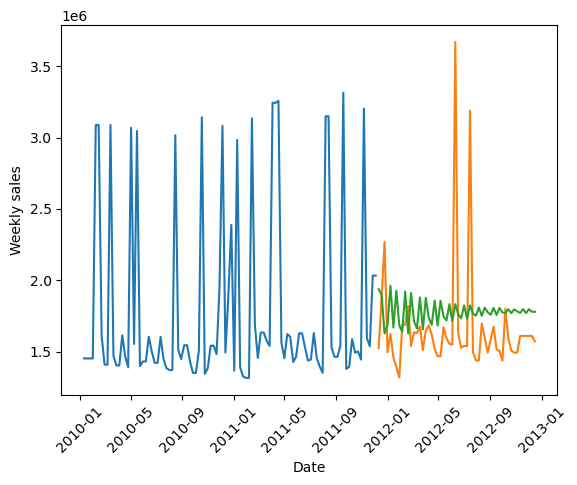

In [38]:
predictions1_converted=predictions1.reset_index(drop=True)
# Reset the index of the 'test1' dataframe to include 'date' as a regular column
test1_copy=test1
test1_copy=test1_copy.reset_index()
test1_copy['predicted'] = predictions1_converted

# Set 'date' column as the index again
test1_copy.set_index('Date', inplace=True)
test1_copy=test1_copy[['Weekly_Sales','predicted']]
plt.plot(train1['Weekly_Sales'],label='Trained data')
plt.plot(test1_copy['Weekly_Sales'],label='Test data')
plt.plot(test1_copy['predicted'],label='Predicted_data')
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Weekly sales")


In [39]:
def time1(store_no):
    df = pd.read_csv('w.csv')
    df_store = df[df['Store'] == store_no]
    df_store = df_store[['Date', 'Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI']]
    df_store['Date'] = pd.to_datetime(df_store['Date'])
    df_store.set_index(['Date'], inplace=True)
    df_store = df_store.sort_index()
    df_store = df_store.resample('W').sum()
    df_store.replace(0, np.nan, inplace=True)
    df_store = df_store.interpolate(method='pad')
    conv_count = (df_store['Weekly_Sales'] == 0).sum()

    if conv_count == 0:
        print("There are no records with a value of 0")
    else:
        print("There are {} records with a value of 0".format(conv_count))

    result = adfuller(df_store['Weekly_Sales'])

    if result[1] > 0.05:
        print("The series {} is not stationary".format(store_no))
    else:
        print("The series {} is stationary".format(store_no))


In [40]:
#Code to check if records corresponding to each store_id are stationary  
for i in range(1,46):
        df = pd.read_csv('w.csv')
        df_store = df[df['Store'] == i]
        df_store = df_store[['Date', 'Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI']]
        df_store['Date'] = pd.to_datetime(df_store['Date'])
        df_store.set_index(['Date'], inplace=True)
        df_store = df_store.sort_index()
        df_store = df_store.resample('W').sum()
        df_store.replace(0, np.nan, inplace=True)
        df_store = df_store.interpolate(method='pad')
        conv_count = (df_store['Weekly_Sales'] == 0).sum()
    
        if conv_count == 0:
              print("There are no records with a value of 0")
        else:
             print("There are {} records with a value of 0".format(conv_count))

        result = adfuller(df_store['Weekly_Sales'])

        if result[1] > 0.05:
              print("The series {} is not stationary".format(i))
        else:
               print("The series {} is stationary".format(i))
        
    

C:\Users\hp\AppData\Local\Temp\ipykernel_19932\3036204698.py:6: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_store['Date'] = pd.to_datetime(df_store['Date'])
C:\Users\hp\AppData\Local\Temp\ipykernel_19932\3036204698.py:6: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_store['Date'] = pd.to_datetime(df_store['Date'])
C:\Users\hp\AppData\Local\Temp\ipykernel_19932\3036204698.py:6: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_store['Date'] = pd.to_datetime(df_store['Date'])
C:\Users\hp\AppData\Local\Temp\ipykernel_19932\3036204698.py:6: UserWarning:

There are no records with a value of 0
The series 1 is stationary
There are no records with a value of 0
The series 2 is stationary
There are no records with a value of 0
The series 3 is stationary
There are no records with a value of 0
The series 4 is stationary
There are no records with a value of 0
The series 5 is stationary
There are no records with a value of 0
The series 6 is stationary
There are no records with a value of 0
The series 7 is stationary
There are no records with a value of 0
The series 8 is stationary
There are no records with a value of 0
The series 9 is stationary
There are no records with a value of 0
The series 10 is stationary
There are no records with a value of 0
The series 11 is stationary
There are no records with a value of 0
The series 12 is stationary
There are no records with a value of 0
The series 13 is stationary
There are no records with a value of 0
The series 14 is stationary
There are no records with a value of 0
The series 15 is stationary
Ther

C:\Users\hp\AppData\Local\Temp\ipykernel_19932\3036204698.py:6: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_store['Date'] = pd.to_datetime(df_store['Date'])
C:\Users\hp\AppData\Local\Temp\ipykernel_19932\3036204698.py:6: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_store['Date'] = pd.to_datetime(df_store['Date'])
C:\Users\hp\AppData\Local\Temp\ipykernel_19932\3036204698.py:6: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_store['Date'] = pd.to_datetime(df_store['Date'])
C:\Users\hp\AppData\Local\Temp\ipykernel_19932\3036204698.py:6: UserWarning:

The series 18 is stationary
There are no records with a value of 0
The series 19 is stationary
There are no records with a value of 0
The series 20 is stationary
There are no records with a value of 0
The series 21 is stationary
There are no records with a value of 0
The series 22 is stationary
There are no records with a value of 0
The series 23 is stationary
There are no records with a value of 0
The series 24 is stationary
There are no records with a value of 0
The series 25 is stationary
There are no records with a value of 0
The series 26 is stationary


C:\Users\hp\AppData\Local\Temp\ipykernel_19932\3036204698.py:6: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_store['Date'] = pd.to_datetime(df_store['Date'])
C:\Users\hp\AppData\Local\Temp\ipykernel_19932\3036204698.py:6: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_store['Date'] = pd.to_datetime(df_store['Date'])
C:\Users\hp\AppData\Local\Temp\ipykernel_19932\3036204698.py:6: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_store['Date'] = pd.to_datetime(df_store['Date'])
C:\Users\hp\AppData\Local\Temp\ipykernel_19932\3036204698.py:6: UserWarning:

There are no records with a value of 0
The series 27 is stationary
There are no records with a value of 0
The series 28 is stationary
There are no records with a value of 0
The series 29 is stationary
There are no records with a value of 0
The series 30 is stationary
There are no records with a value of 0
The series 31 is stationary
There are no records with a value of 0
The series 32 is stationary
There are no records with a value of 0
The series 33 is stationary
There are no records with a value of 0
The series 34 is stationary
There are no records with a value of 0
The series 35 is stationary
There are no records with a value of 0
The series 36 is not stationary
There are no records with a value of 0
The series 37 is stationary
There are no records with a value of 0
The series 38 is stationary
There are no records with a value of 0
The series 39 is stationary
There are no records with a value of 0
The series 40 is stationary
There are no records with a value of 0
The series 41 is st

C:\Users\hp\AppData\Local\Temp\ipykernel_19932\3036204698.py:6: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_store['Date'] = pd.to_datetime(df_store['Date'])
C:\Users\hp\AppData\Local\Temp\ipykernel_19932\3036204698.py:6: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_store['Date'] = pd.to_datetime(df_store['Date'])
C:\Users\hp\AppData\Local\Temp\ipykernel_19932\3036204698.py:6: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_store['Date'] = pd.to_datetime(df_store['Date'])
C:\Users\hp\AppData\Local\Temp\ipykernel_19932\3036204698.py:6: UserWarning:

There are no records with a value of 0
The series 43 is stationary
There are no records with a value of 0
The series 44 is stationary
There are no records with a value of 0
The series 45 is stationary


C:\Users\hp\AppData\Local\Temp\ipykernel_19932\3036204698.py:6: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_store['Date'] = pd.to_datetime(df_store['Date'])
C:\Users\hp\AppData\Local\Temp\ipykernel_19932\3036204698.py:6: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_store['Date'] = pd.to_datetime(df_store['Date'])
